In [1]:
from model import load_model, regression_net
from tqdm import tqdm

import numpy as np
import nibabel as nib

import cv2
import os
import time

C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hasee007\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hasee007\AppData\Roaming\Python\Py

In [2]:
data_root = 'example/data'
model_path = 'example/model'
result_path = 'example/result'
mask_path = 'example/mask'

In [3]:
input_path = os.path.join(data_root, './')

In [4]:
method = 'regression'
method_path = os.path.join(model_path, 'regress.hdf5')

In [5]:
method_net = regression_net(pretrained_weights=method_path)

In [6]:
# min max scaler
def min_max_scaler(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))


# crop roi for unet prediction
def crop_roi(img):
    test_img = np.rot90(min_max_scaler(img))
    crop_img = test_img[130:130 + 160, 50:50 + 224]
    return crop_img

In [7]:
NII_fileList = []
for dirName, subdirList, fileList in os.walk(input_path):
    for filename in fileList:
        if ".nii" in filename.lower():
            # print filename
            NII_fileList.append(os.path.join(dirName, filename))

In [8]:
res_list = []
for file in tqdm(NII_fileList, desc='Detect in {}'.format(os.path.abspath(input_path))):
    filename = os.path.basename(file)
    output_name = '{}_detect_by_{}'.format(filename.split('.')[-2], method)
    output_path = os.path.join(result_path, output_name)
    data = nib.load(file)
    width, height, frame_num = data.shape
    matrix = data.get_data()
    img_batch = np.transpose(matrix, (2, 0, 1))
    batch, h, w = img_batch.shape
    crop_batch = []
    for img in img_batch:
        crop_img = crop_roi(img)
        crop_batch.append(crop_img)
    crop_batch = np.array(crop_batch)
    crop_batch = np.reshape(crop_batch, crop_batch.shape + (1,))
    
    res = method_net.predict_on_batch(crop_batch)
    np.save(output_path, res)
    res_list.append(res)

Detect in F:\GitHub\DICOM\example\data:   0%|                                                                                                                                               | 0/4 [00:00<?, ?it/s]

Detect in F:\GitHub\DICOM\example\data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.37it/s]


In [9]:
from matplotlib import pyplot as plt

In [10]:
result_method = 'regression'

In [11]:
data_filename = '0507_90day50u_20190812_mouse51SWI.nii'
data_path = os.path.join(data_root, data_filename)
mask_filename = os.path.join(mask_path, '51.nii')
result_filename = os.path.join(result_path, '{}_detect_by_{}.npy'.format(data_filename.split('.')[-2], result_method))
print('Data: {}\nGround True: {}\nResult: {}\n'.format(data_path, mask_filename, result_filename))

Data: example/data\0507_90day50u_20190812_mouse51SWI.nii
Ground True: example/mask\51.nii
Result: example/result\0507_90day50u_20190812_mouse51SWI_detect_by_regression.npy



In [12]:
data = nib.load(data_path)
mask = nib.load(mask_filename)
result = np.load(result_filename)

In [13]:
data_matrix = data.get_data()
gt_matrix = mask.get_data()

In [14]:
data_matrix.shape

(300, 300, 30)

In [34]:
frame_num = 15
threshold = 0.50

In [35]:
img = data_matrix[:, :, frame_num]
gt = gt_matrix[:, :, frame_num]
pred = result[frame_num]

In [36]:
from vis.visualization import visualize_saliency
from vis.utils import utils

In [37]:
layer_idx = utils.find_layer_idx(method_net, 'output')
crop_img = crop_roi(img)
crop_gt = crop_roi(gt)
crop_img = np.reshape(crop_img, crop_img.shape + (1,))

In [38]:
saliency_map = visualize_saliency(model=method_net, layer_idx=layer_idx, filter_indices=0, seed_input=crop_img)
thres_map = np.zeros_like(saliency_map)
thres_map[saliency_map > threshold] = 1

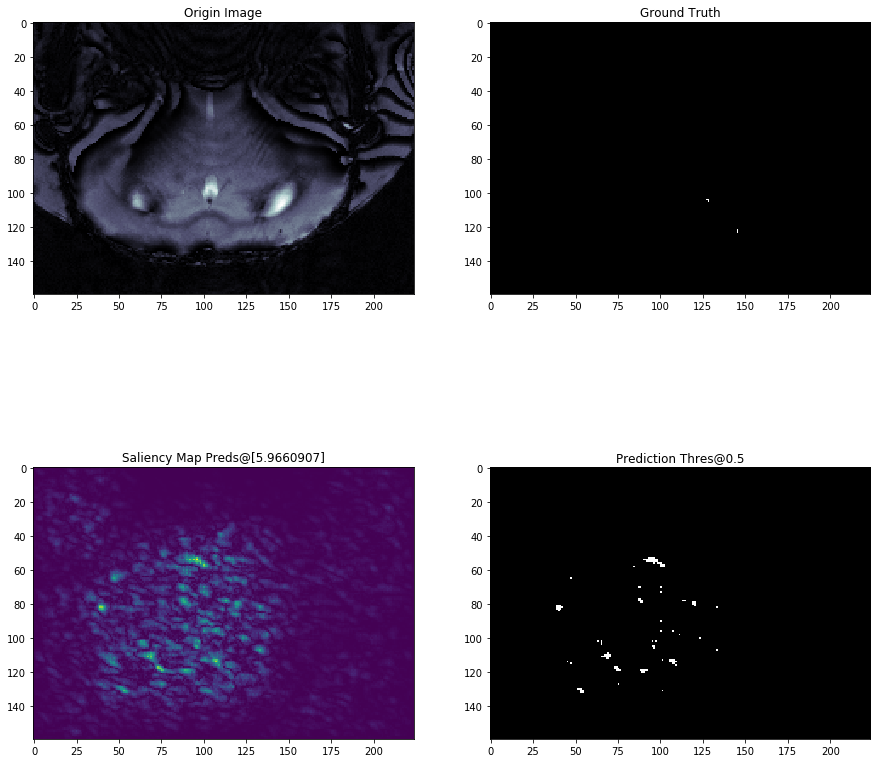

In [39]:
plt.figure(figsize=(15, 15))
plt.subplot(221)
plt.title('Origin Image')
plt.imshow(crop_img[:, :, 0], cmap='bone')
plt.subplot(222)
plt.title('Ground Truth')
plt.imshow(crop_gt, cmap='bone')
#plt.scatter(np.where(crop_gt == 1)[1], np.where(crop_gt == 1)[0], c='Red', s=3)
plt.subplot(223)
plt.title('Saliency Map Preds@{}'.format(pred))
plt.imshow(saliency_map)
plt.subplot(224)
plt.title('Prediction Thres@{}'.format(threshold))
plt.imshow(thres_map, cmap='bone')

In [21]:
import cv2

In [22]:
gt_nums = []
for frame_num in range(30):
    gt = gt_matrix[:, :, frame_num]
    gt_num, _ = cv2.connectedComponents(np.uint8(gt))
    gt_nums.append(gt_num)
gt_nums = np.array(gt_nums)

In [23]:
result

array([[2.384121 ],
       [2.090232 ],
       [5.7045927],
       [7.136117 ],
       [5.5917416],
       [4.4369645],
       [6.3226566],
       [6.1902804],
       [5.5956206],
       [5.7069554],
       [7.619477 ],
       [6.630413 ],
       [8.139927 ],
       [8.14861  ],
       [5.885228 ],
       [5.9660907],
       [5.3409557],
       [3.599874 ],
       [2.9652185],
       [3.8379388],
       [4.809775 ],
       [1.4372389],
       [2.752613 ],
       [1.882649 ],
       [0.9893371],
       [1.0330236],
       [0.9793749],
       [1.3088374],
       [2.2024066],
       [1.3137834]], dtype=float32)

In [24]:
gt_nums

array([1, 1, 2, 3, 5, 7, 2, 6, 1, 2, 1, 5, 4, 8, 4, 3, 3, 2, 3, 4, 4, 3,
       1, 2, 2, 2, 1, 1, 1, 1])

In [25]:
np.mean(np.square(gt_nums - result))

10.794493097433323

In [26]:
np.mean(np.abs(gt_nums - result))

2.6763758381207783

In [27]:
np.corrcoef(np.vstack((gt_nums, np.squeeze(result))))

array([[1.        , 0.52829032],
       [0.52829032, 1.        ]])